### Main libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import seaborn as sns

In [ ]:
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Univariable LSTM

In [ ]:
import sweetviz as sv
from statsmodels.tsa.seasonal import STL

In [ ]:
df_price = pd.read_csv('agrodata.csv')
df_weather = pd.read_csv('agroweather_data.csv')

In [ ]:
df_price['Price'] = df_price['Price'].astype(float)
Price = df_price['Price']
Price

0       74.0
1       81.0
2       77.0
3       73.0
4       67.0
       ...  
983    125.0
984    125.0
985    124.0
986    122.0
987    115.0
Name: Price, Length: 988, dtype: float64

In [ ]:
def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [ ]:
train = Price[:700]
val = Price[700:850]
test = Price[850:]

In [ ]:
WINDOW_SIZE = 5
X, y = df_to_X_y(train, WINDOW_SIZE)
X.shape, y.shape

((695, 5, 1), (695,))

In [ ]:
X_test, y_test = df_to_X_y(test, WINDOW_SIZE)
X_test.shape, y_test.shape

((133, 5, 1), (133,))

In [ ]:
X_val, y_val = df_to_X_y(val, WINDOW_SIZE)
X_val.shape, y_val.shape

((145, 5, 1), (145,))

In [ ]:
X_test[0] # Estamos usando 5 días para producir una predicción de 1 día, es decir, usamos los 5 días anteriores incluyendo hoy, para realizar la predicción de mañana.9

array([[184.],
       [249.],
       [282.],
       [227.],
       [223.]])

In [ ]:
y_test[0]

204.0

In [ ]:
X_val, y_val = df_to_X_y(val, WINDOW_SIZE)
X_val.shape, y_val.shape

((145, 5, 1), (145,))

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras import regularizers

In [ ]:
model = Sequential()
model.add(InputLayer((5, 1)))
model.add(LSTM((64), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,667 (69.01 KB)

 Trainable params: 17,667 (69.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cp = ModelCheckpoint('model1.keras', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate = 0.001), metrics=[RootMeanSquaredError()])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 25, verbose = 1, restore_best_weights=True)

In [ ]:
model.fit(X, y, validation_data=(X_val, y_val), epochs = 250, callbacks =[early_stopping, cp])

Epoch 1/250


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 14719.7148 - root_mean_squared_error: 120.9884 - val_loss: 36838.7461 - val_root_mean_squared_error: 192.5905
Epoch 2/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13595.5664 - root_mean_squared_error: 116.5358 - val_loss: 36378.0234 - val_root_mean_squared_error: 191.3930
Epoch 3/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11760.4912 - root_mean_squared_error: 108.4315 - val_loss: 35297.6562 - val_root_mean_squared_error: 188.5563
Epoch 4/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10944.1973 - root_mean_squared_error: 104.5384 - val_loss: 31591.9688 - val_root_mean_squared_error: 178.5635
Epoch 5/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8823.3682 - root_mean_squared_error: 93.9002 - val_loss: 27074.8945 - val_root_mean_squared_error: 165.4801
Epoch 6/250
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6301.3540 - root_mean_squared_error: 79.3401 - val_loss: 22556.3125 - val_root_mean_squared_error: 151.3353
Ep

In [ ]:
def predict_n_steps(model, X_input, n_steps):
    # X_input es la última secuencia observada (por ejemplo, los precios de los últimos 5 días)
    predictions = []
    current_sequence = X_input.copy()
    
    for _ in range(n_steps):
        # Hacer la predicción para el próximo punto
        next_prediction = model.predict(current_sequence[np.newaxis, :])
        predictions.append(next_prediction[0, 0])
        
        # Actualizar la secuencia de entrada con la última predicción
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_prediction
        
    return predictions


last_sequence = X_test[-1]
future_steps = 15  # Pasos a predecir

predictions = predict_n_steps(model, last_sequence, future_steps)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[118.67437, 115.24846, 112.02124, 109.122665, 106.47847, 104.042984, 101.784836, 99.697266, 97.77704, 96.022354, 94.43007, 92.99642, 91.71637, 90.583405, 89.58937]


In [ ]:
X_test.shape

(133, 5, 1)

In [ ]:
y_test.shape

(133,)

In [ ]:
comparativa = pd.DataFrame(data={'Predictions':predictions[:10], 'Actuals':y_test[:10]})
comparativa

,Predictions,Actuals
0,118.674370,204.0
1,115.248459,191.0
2,112.021240,177.0
3,109.122665,179.0
4,106.478470,186.0
5,104.042984,163.0
6,101.784836,161.0
7,99.697266,164.0
8,97.777039,171.0
9,96.022354,178.0


In [ ]:
train_predictions = model.predict(X_test).flatten()
train_results = pd.DataFrame(data = {'Predictions':train_predictions, 'Actuals':y_test})
train_results

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Predictions,Actuals
0,222.915802,204.0
1,188.062286,191.0
2,180.246765,177.0
3,165.908432,179.0
4,171.284546,186.0
...,...,...
128,125.011070,125.0
129,120.520248,125.0
130,122.449524,124.0
131,121.226761,122.0


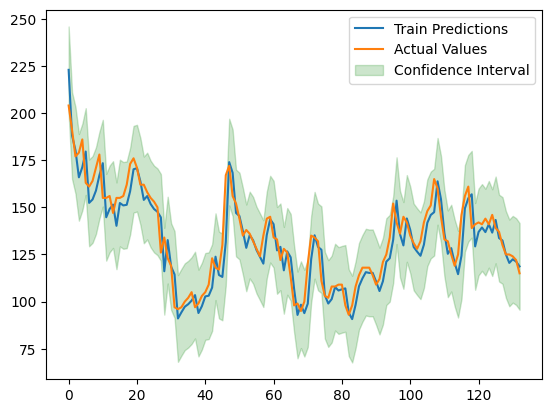

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(train_results['Predictions'])
plt.plot(train_results['Actuals'])
# Suponiendo que tienes las predicciones y los intervalos de confianza en train_results
upper_bound = train_results['Predictions'] + 23
lower_bound = train_results['Predictions'] - 23

plt.fill_between(train_results.index, lower_bound, upper_bound, color='green', alpha=0.2)
plt.legend(['Train Predictions', 'Actual Values', 'Confidence Interval'])
plt.show()
plt.clf()

In [ ]:
mae = tf.keras.losses.MeanAbsoluteError()

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
result = mean_absolute_error(train_results['Actuals'], train_results['Predictions'])
print(f"El error obtenido con LSTM es de {round((result / 100), 2)}€")

El error obtenido con LSTM es de 0.07€


Tenemos un error medio absoluto de 11 céntimos cuando queremos predecir el día siguiente con una ventana de tiempo (número de días de referencia) de 5 días.

In [ ]:
lstm_error = abs(comparativa['Actuals'] - comparativa['Predictions'])
lstm_error.describe() # Aquí podemos ver la distribución de nuestra pérdida a la hora de hacer la predicción.

count    10.000000
mean     71.313032
std       9.375930
min      58.957016
25%      64.471741
50%      71.550148
75%      78.579033
max      85.325630
dtype: float64

<function matplotlib.pyplot.clf() -> 'None'>

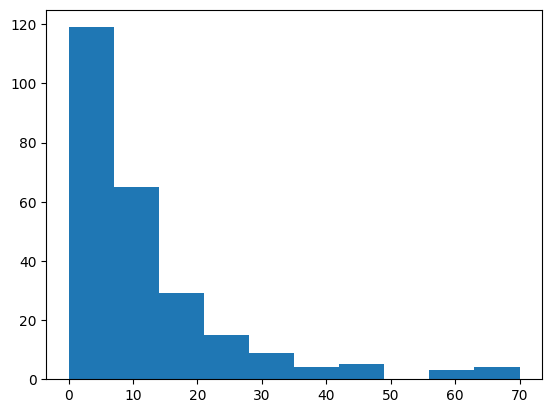

In [ ]:
plt.hist(lstm_error)
plt.plot()
plt.clf

In [ ]:
value2 = abs(comparativa['Actuals'] - comparativa['Predictions'])
value2.describe() 

count    10.000000
mean     70.879372
std      22.737464
min      30.364578
25%      55.555784
50%      80.909554
75%      89.017435
max      91.142494
dtype: float64

Tenemos una media de 70 céntimos de error cuando queremos predecir 15 días hacia adelante utilizando una ventana de tiempo (referencia de precios) de los últimos 5 días.